### Investigating the impact of including past test data on model performance

In [222]:
# --- Core libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Machine learning models ---
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor

# --- Model selection ---
from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    GridSearchCV
)

# --- Preprocessing & pipeline ---
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Metrics ---
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error

# --- Configuration ---
from sklearn import set_config


****
**This notebook focuses on a different testing method where we predict one day ahead and then retrain the model based on that data.**
****

**Reading the data and making the Time series split we use for the cross validation**

In [223]:
#read data
final_data = pd.read_csv('final_data_train.csv', index_col='ts')

X = final_data.drop(columns=["power", "ts"], errors="ignore")
y = final_data["power"]

tscv = TimeSeriesSplit(n_splits=5)

Training a OLS model - Defining a pipeline to pass the scaling and model type efficiently into Grid Search. There of course is no parameter to grid search over, reason for the empty parameter grid in an OLS, but we use this framework for completeness as the other models do as well, and for the easiness of cross validation. 

In [224]:
OLSpipe = Pipeline([
    ('Scaling', StandardScaler()),
    ('model', LinearRegression())
    ])


OLS_model = GridSearchCV( 
    OLSpipe,
    cv=tscv,
    param_grid= {},
    scoring="neg_root_mean_squared_error", 
    n_jobs=-1
)

OLS_model.fit(X, y) #Fit the model

fitted = OLS_model.predict(X) #Extract the fit

#Evaluate best non-linear model
print("\n OLS")
print("----------------------------------------------------")
print(f"CV best score (RMSE): {-OLS_model.best_score_:.3f}")
print(f'Fit on training set {root_mean_squared_error(fitted, y)}')


 OLS
----------------------------------------------------
CV best score (RMSE): 0.821
Fit on training set 0.29835863349585984


First we tested with the whole feature space, which is not ideal for simple models like OLS, so now we have reduced the features *(see code on feature reduction)* to try and improve the model

In [225]:
# --- 1) Define target + selected features ---
selected_features = [
    "mean_IGR_Nex", "mean_temp_Nex", "mean_hum_Nex",
    "prec_Nex", "mean_wind_speed_Nex", "mean_wind_dir_Nex",
    "DK2_DKK", "SYSTEM_DKK", "ImbalancePriceDKK"
]

X_sel = final_data[selected_features].copy()
y_sel = final_data['power'].copy()



OLS_selected_model = GridSearchCV(
    OLSpipe,  #use the same pipeline as defined above
    cv=tscv,
    param_grid={},  # unchanged
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

OLS_selected_model.fit(X_sel, y_sel) #fit the model
fitted = OLS_selected_model.predict(X_sel) #Extract the fit


print("\n OLS")
print("----------------------------------------------------")
print(f"CV best score (RMSE): {-OLS_selected_model.best_score_:.3f}")
print(f'Fit on training set {root_mean_squared_error(fitted, y_sel)}')


 OLS
----------------------------------------------------
CV best score (RMSE): 0.344
Fit on training set 0.3206759101857598


**Vizualizations** plotting actual vs predicted values

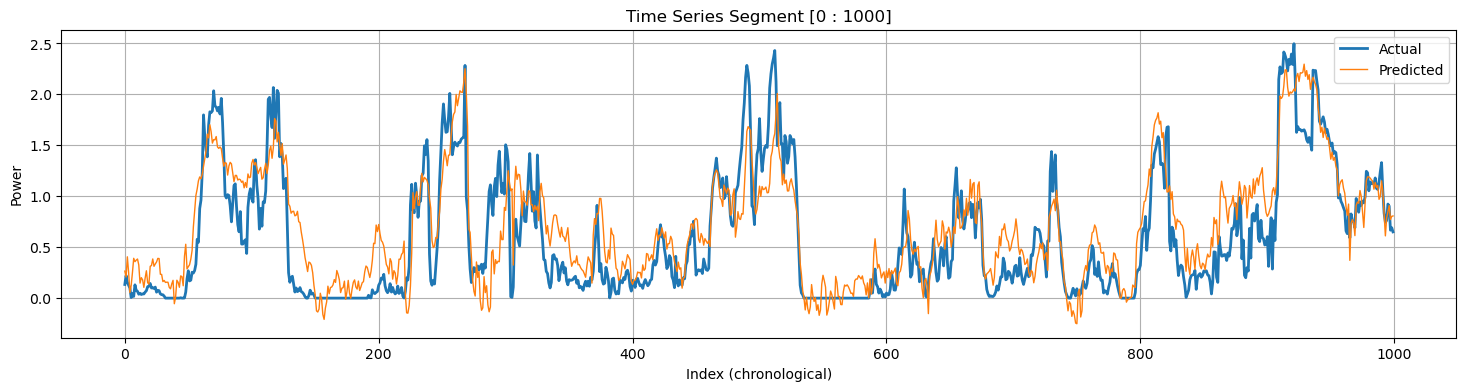

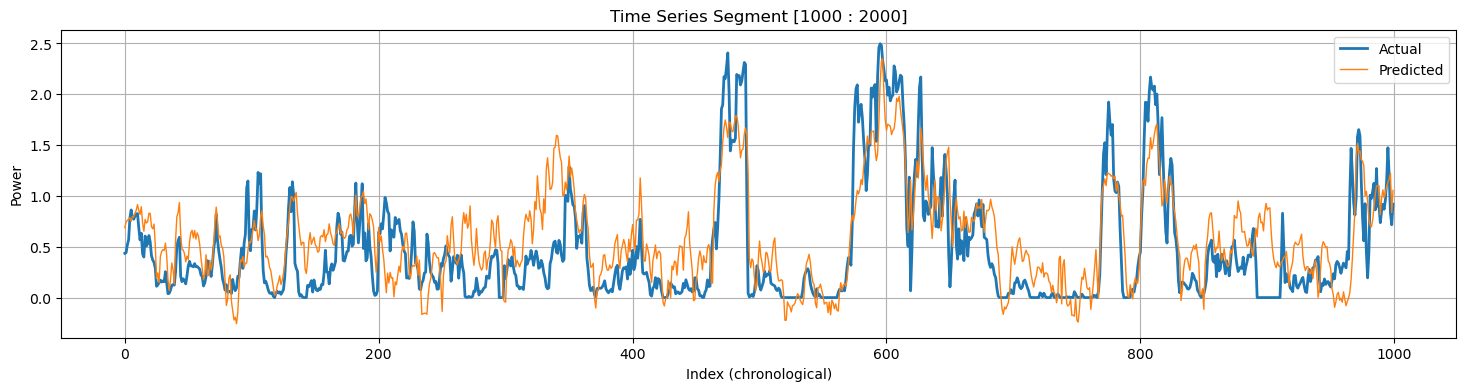

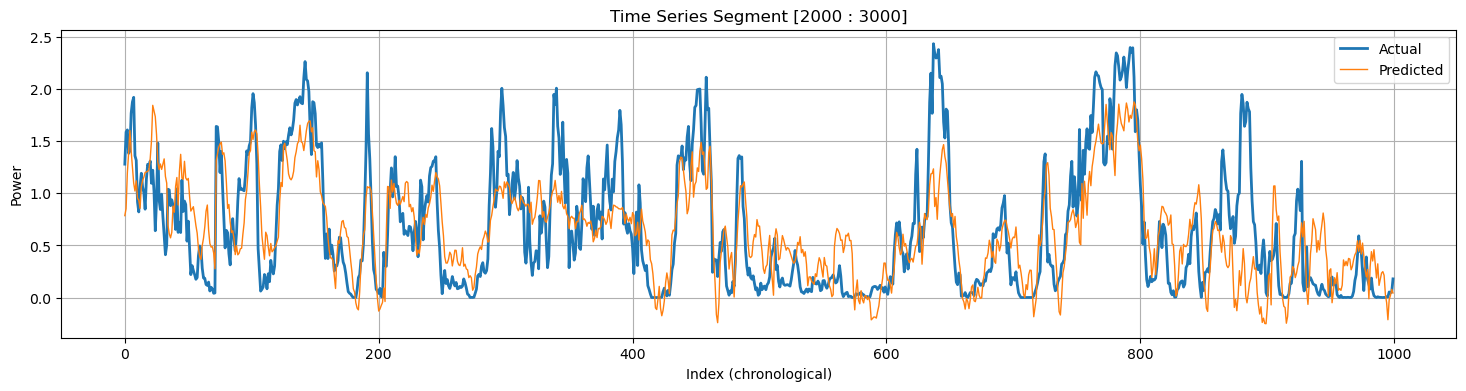

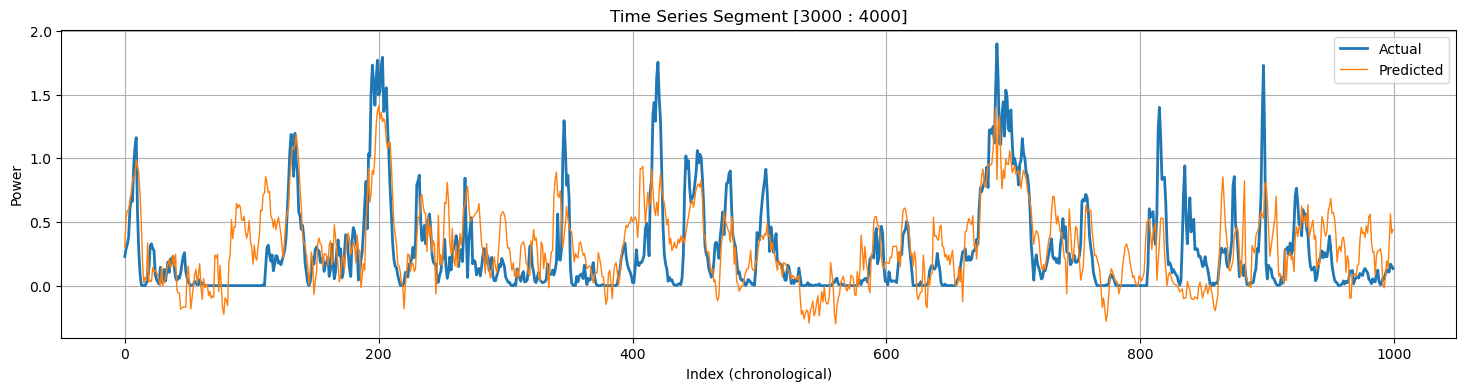

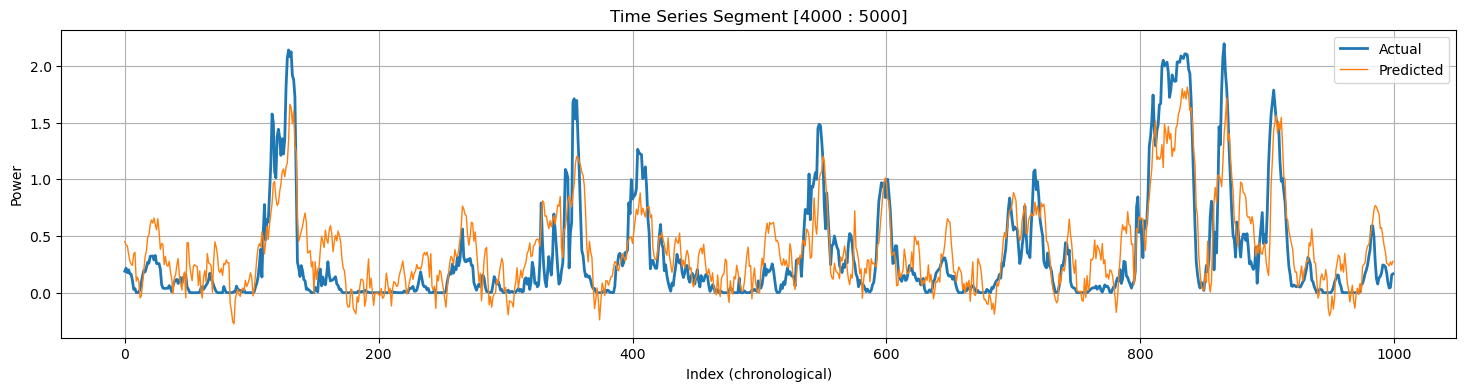

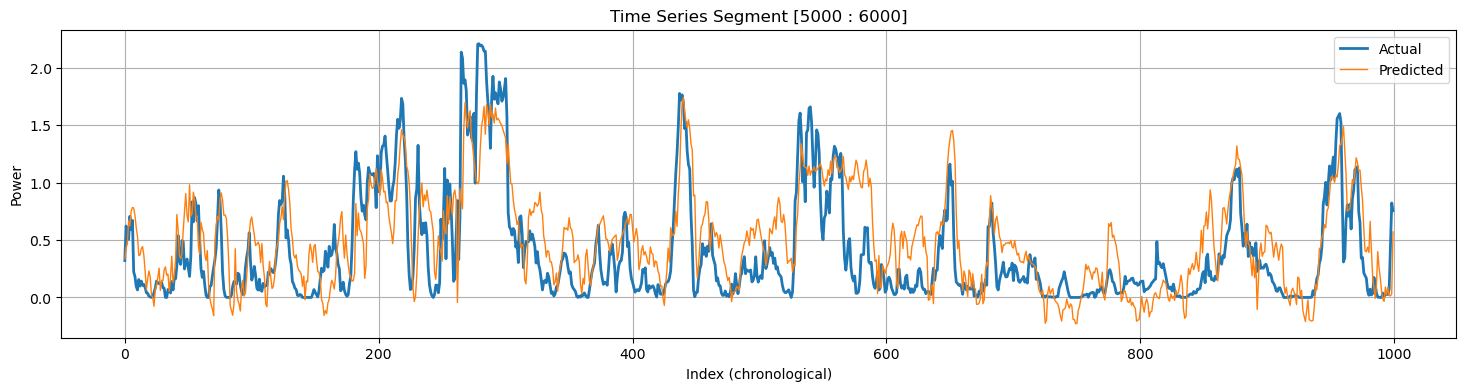

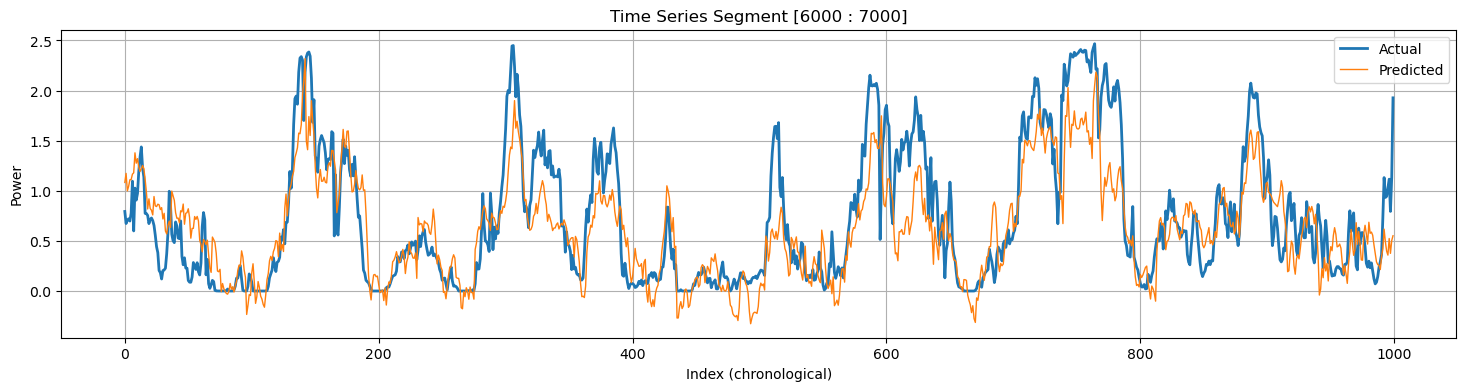

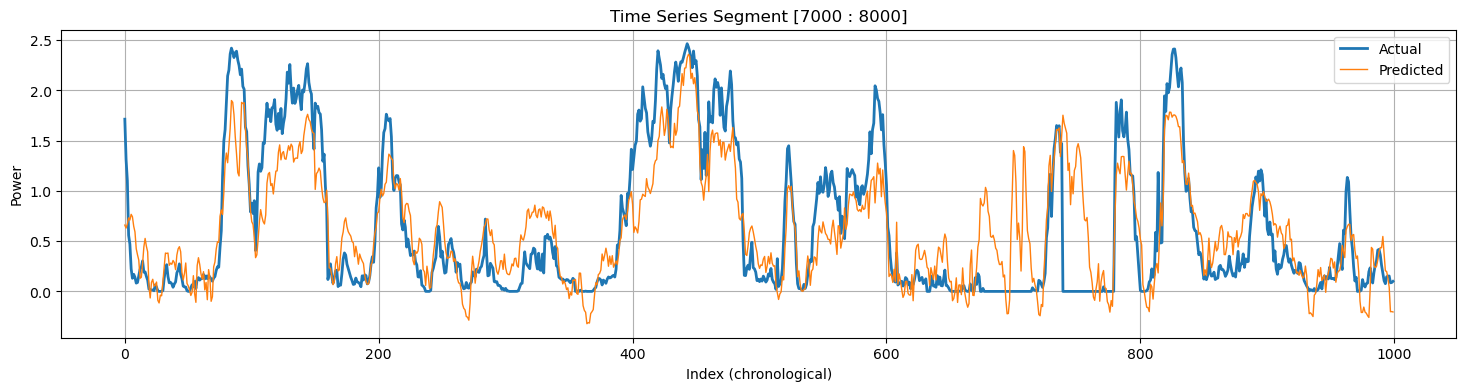

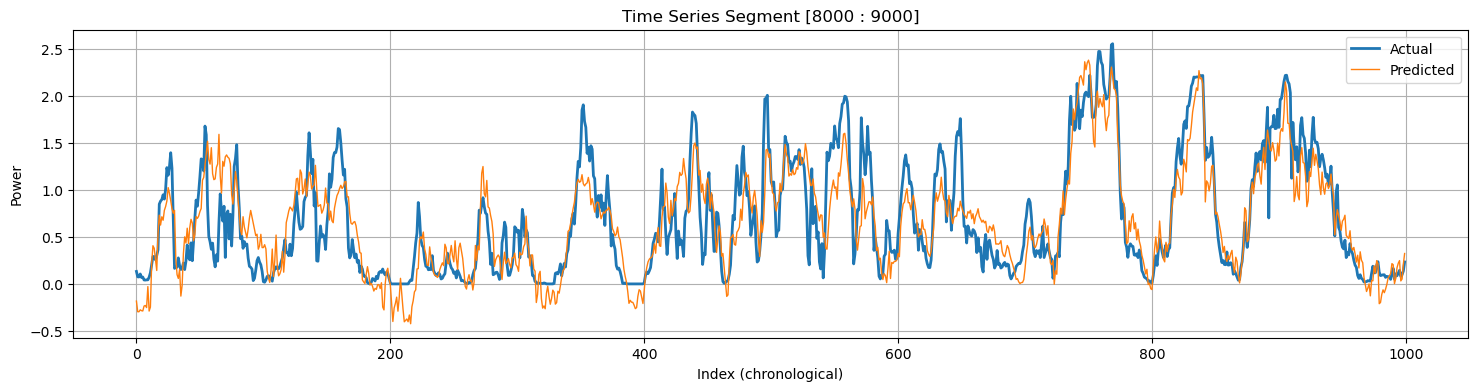

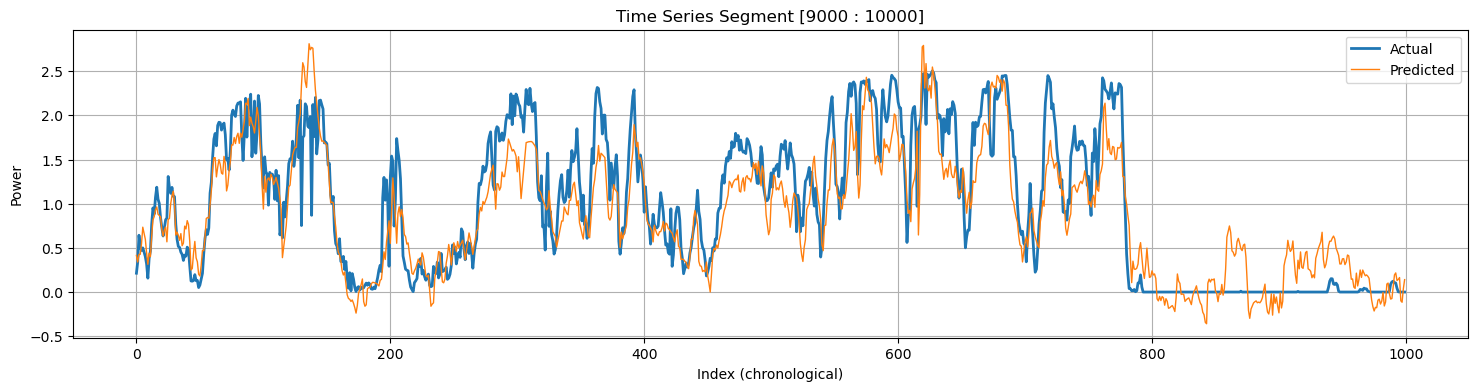

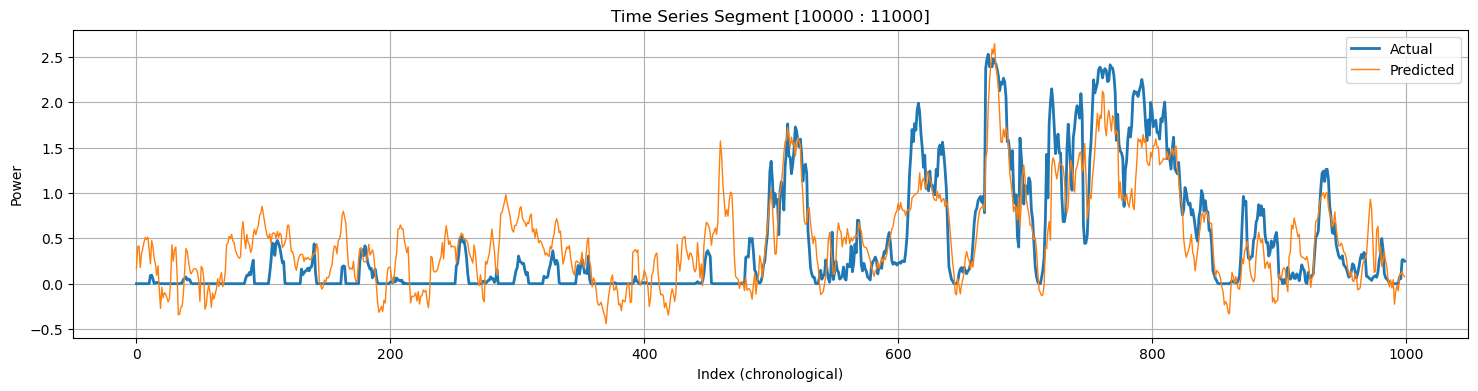

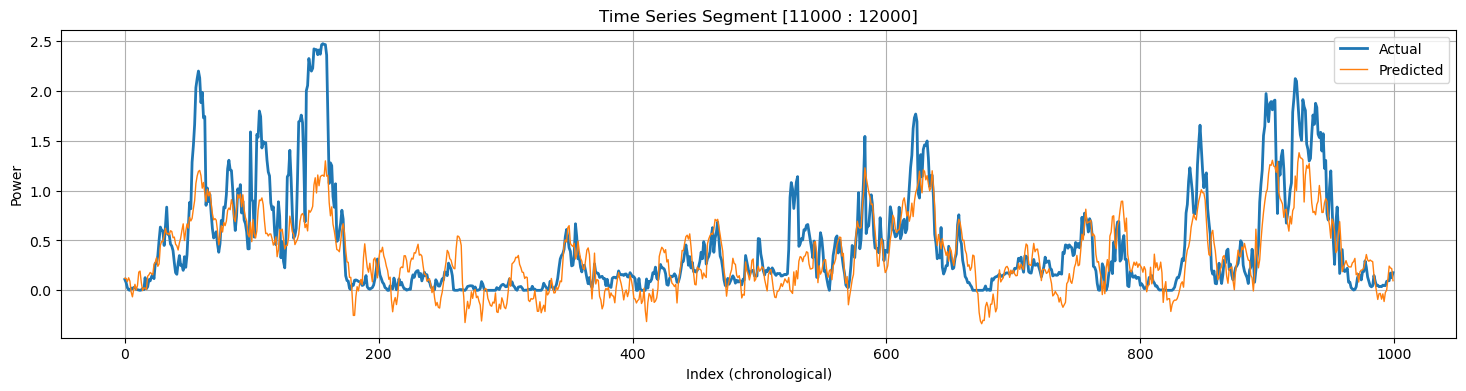

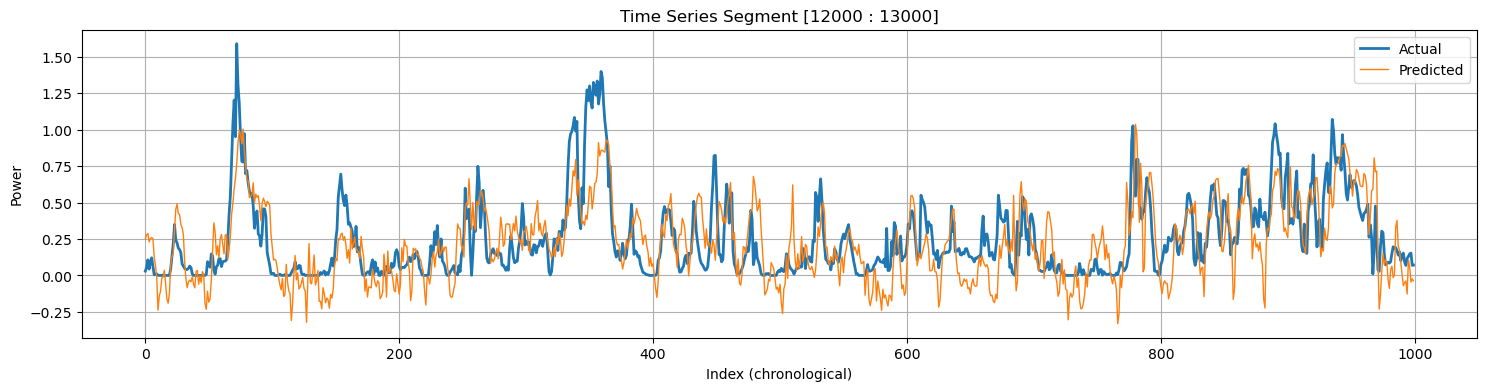

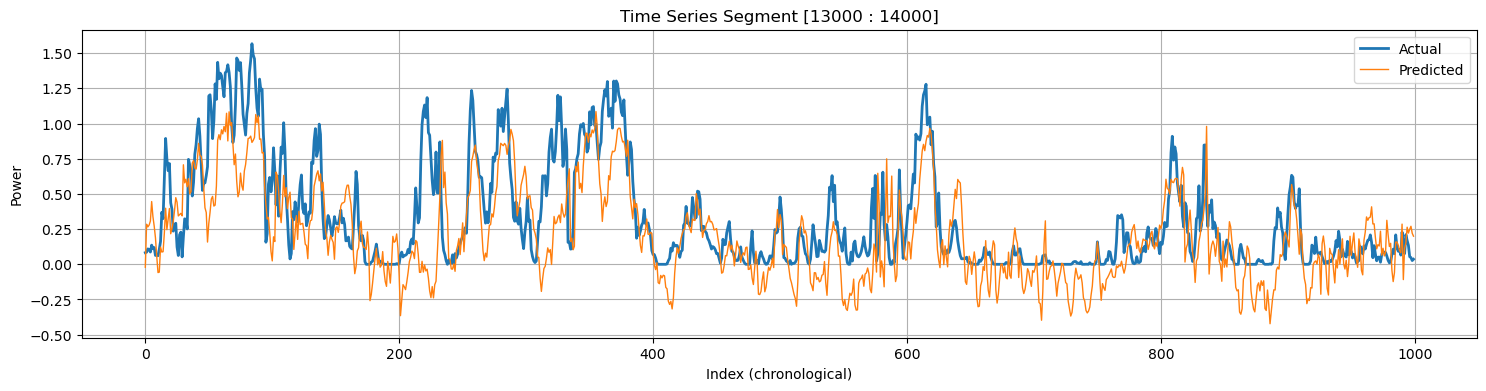

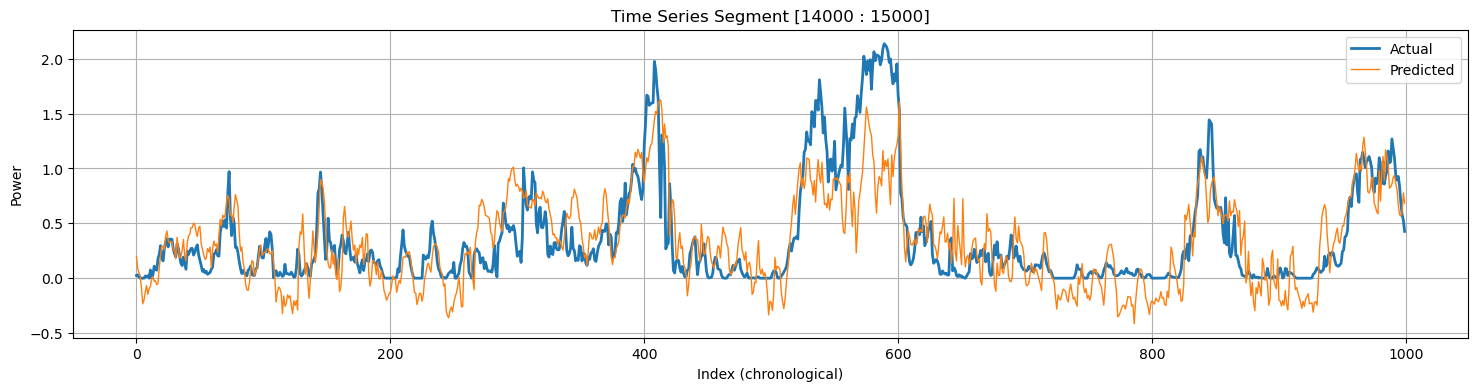

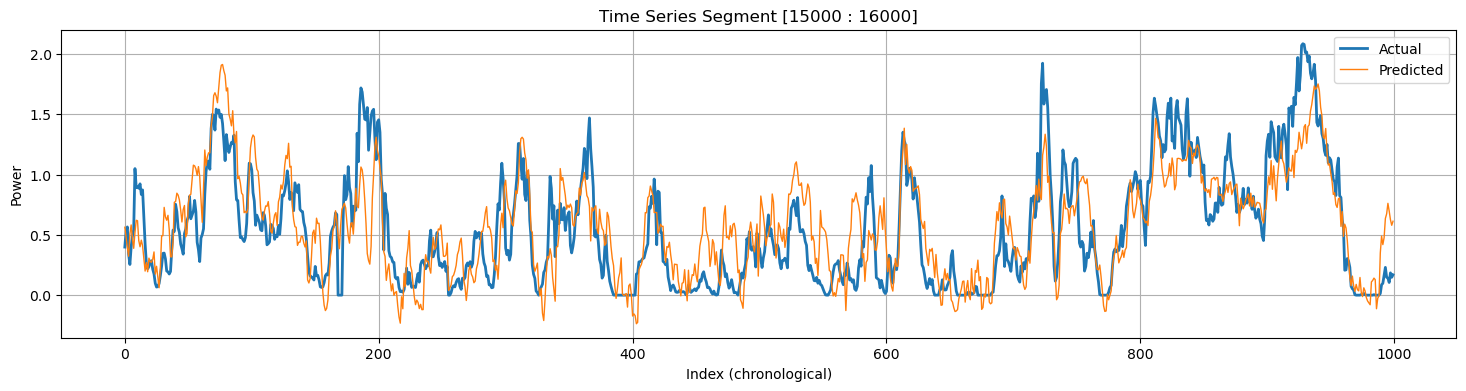

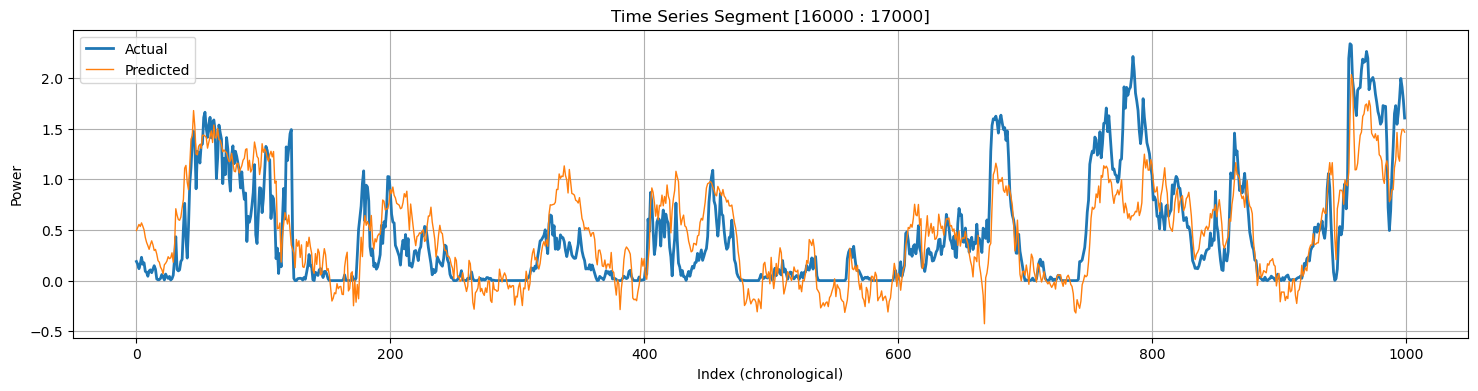

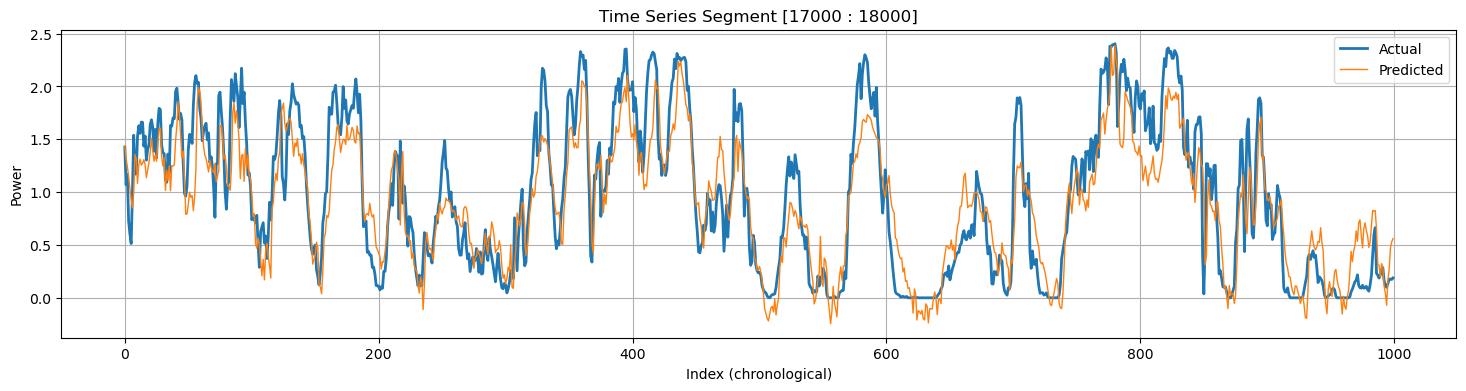

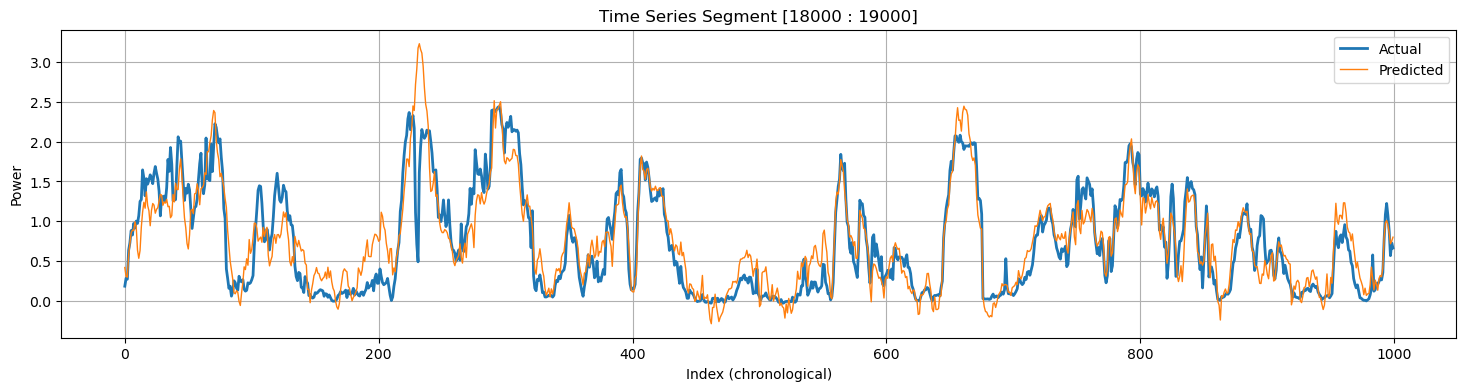

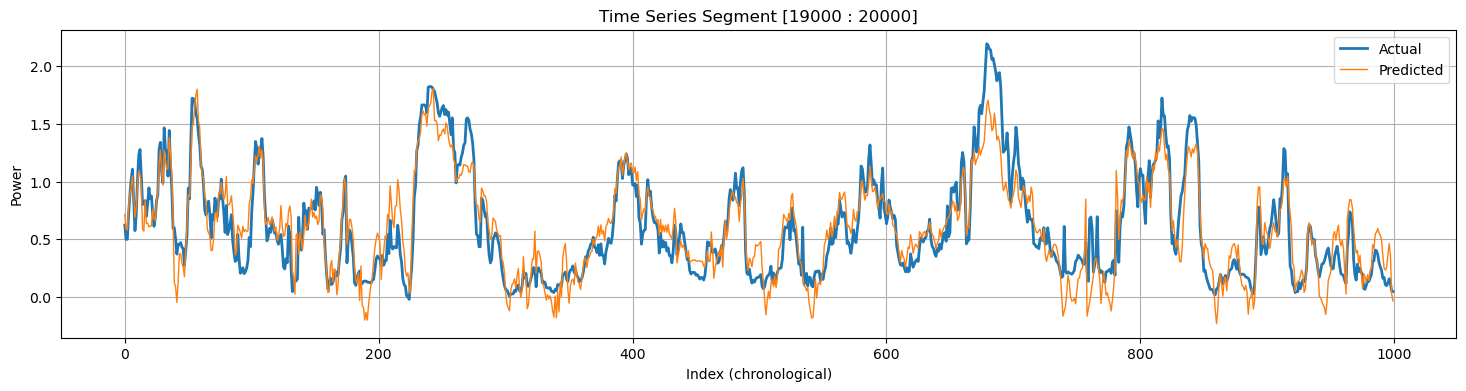

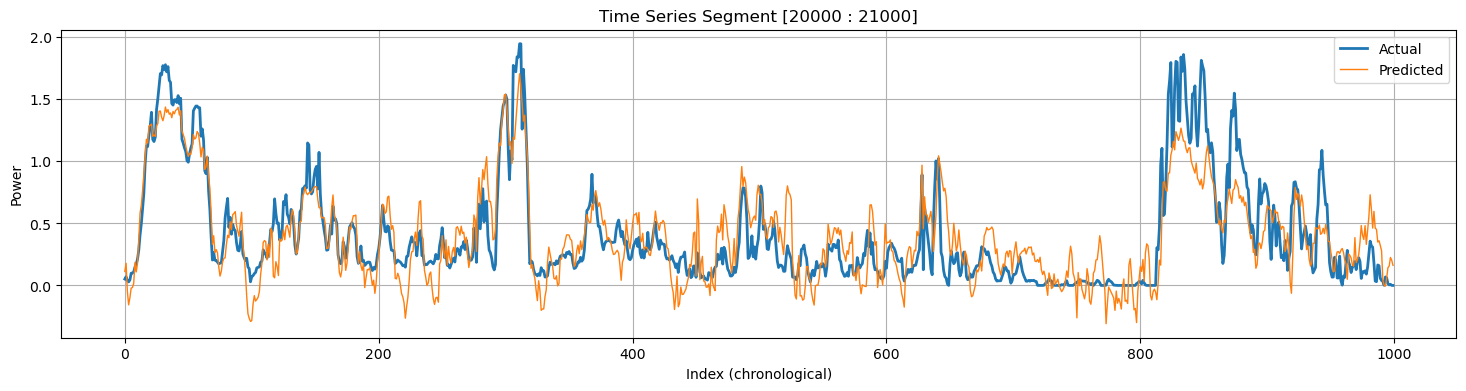

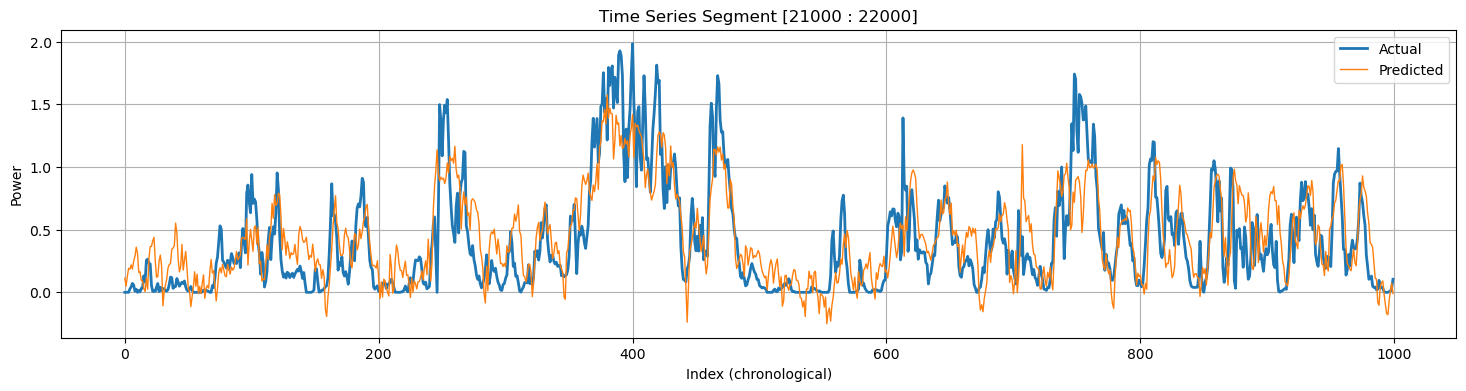

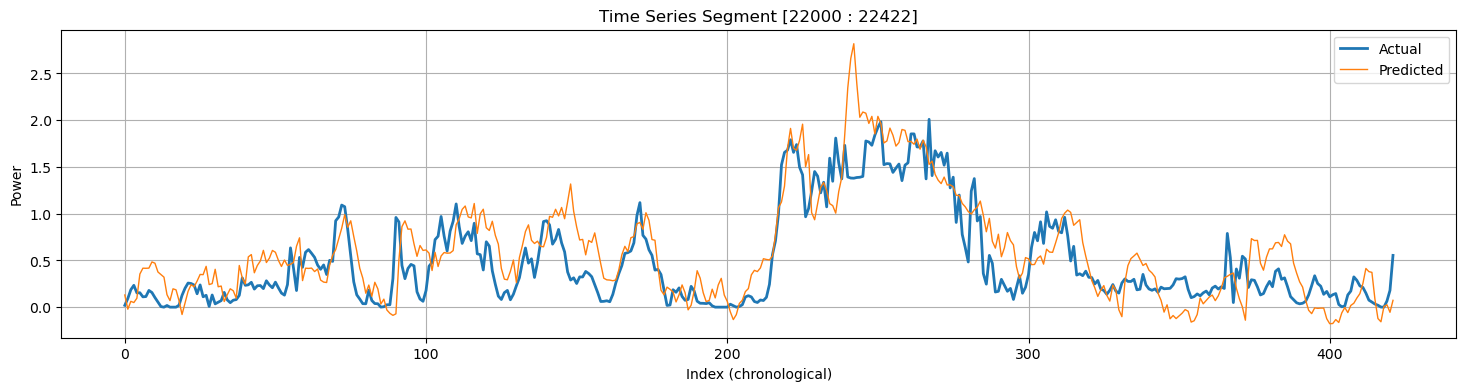

In [226]:
# Make sure predictions exist
y_fit = OLS_selected_model.predict(X_sel)

# Combine predictions & actuals into full timeline
y_pred_full = y_fit
y_actual_full = y.values

window = 1000  # number of points per plot

for start in range(0, len(y_actual_full), window):
    end = min(start + window, len(y_actual_full))

    plt.figure(figsize=(18, 4))
    plt.plot(
        y_actual_full[start:end],
        label="Actual", linewidth=2
    )
    plt.plot(
        y_pred_full[start:end],
        label="Predicted", linewidth=1
    )
    plt.title(f"Time Series Segment [{start} : {end}]")
    plt.xlabel("Index (chronological)")
    plt.ylabel("Power")
    plt.legend()
    plt.grid(True)
    plt.show()


Training the model with all available data, Rolling daly updates

**Non-linear** Now we extend the linear model to a nonlinear one to capture the dynamics better. T

In [227]:
# Keep pandas objects through the pipeline (nice for feature names)
set_config(transform_output="pandas")


selected_to_square = ["mean_wind_speed_Nex", 'mean_wind_speed_Hammer_ Odde_Fyr']
numeric_features   = X.columns.tolist()

# Rename function must accept (transformer, input_features)
def squared_names(_, input_features):
    return [f"{n}^2" for n in input_features]


#selected -> impute -> square (renamed)
square_branch = Pipeline([
    ("square", FunctionTransformer(np.square, feature_names_out=squared_names)),
])

# Combine branches
pre = ColumnTransformer(
    transformers=[
        ("orig",   'passthrough', numeric_features),
        ("sq_sel", square_branch, selected_to_square),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Full pipeline
pipe = Pipeline([
    ("prep", pre),
    ("scaler", RobustScaler()),  
    ("model", LinearRegression())
])

# CV + grid
param_grid = {}

OLS_squared = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

# Fit & evaluate
OLS_squared.fit(X, y)
y_pred_nonlin = OLS_squared.predict(X)

print("\nSelected-squares (CV)")
print("------------------------------")
#print(f"Best alpha: {search.best_params_['model__alpha']}")
print(f"CV best RMSE: {-OLS_squared.best_score_:.3f}")
print(f"fit RMSE: {root_mean_squared_error(y, y_pred_nonlin):.3f}")
print(f"fit R² : {r2_score(y, y_pred_nonlin):.3f}")

## show the evolution of the models, graph table ... 


Selected-squares (CV)
------------------------------
CV best RMSE: 0.738
fit RMSE: 0.295
fit R² : 0.751


**Lasso Non-linear**

In [228]:
# CV + grid


pipe_L = Pipeline([
    ("prep", pre),
    ("scaler", RobustScaler()),  
    ("model", Lasso())
])
param_grid = {"model__alpha": [0.02,0.03,0.2, 1.0, 5,10]}

Lasso_model = GridSearchCV(
    estimator=pipe_L,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

# Fit & evaluate
Lasso_model.fit(X, y)
y_pred_nonlin = Lasso_model.predict(X)

print("\nSelected-squares + Lasso (CV)")
print("------------------------------")
print(f"Best alpha: {Lasso_model.best_params_['model__alpha']}")
print(f"CV best RMSE: {-Lasso_model.best_score_:.3f}")
print(f"fit RMSE: {root_mean_squared_error(y, y_pred_nonlin):.3f}")
print(f"fit R² : {r2_score(y, y_pred_nonlin):.3f}")

## show the evolution of the models, graph table ... 


Selected-squares + Lasso (CV)
------------------------------
Best alpha: 0.02
CV best RMSE: 0.310
fit RMSE: 0.308
fit R² : 0.728


**Ridge Non-linear**

In [229]:
pipe = Pipeline([
    ("prep", pre),
    ("scaler", RobustScaler()),  
    ("model", Ridge())
])
param_grid = {"model__alpha": [0.02,0.03,0.2, 1.0, 5,10]}

Ridge_model = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
)

# Fit & evaluate
Ridge_model.fit(X, y)
y_pred_nonlin = Ridge_model.predict(X)

print("\nSelected-squares + Ridge (CV)")
print("------------------------------")
print(f"Best alpha: {Ridge_model.best_params_['model__alpha']}")
print(f"CV best RMSE: {-Ridge_model.best_score_:.3f}")
print(f"fit RMSE: {root_mean_squared_error(y, y_pred_nonlin):.3f}")
print(f"fit R² : {r2_score(y, y_pred_nonlin):.3f}")


Selected-squares + Ridge (CV)
------------------------------
Best alpha: 0.02
CV best RMSE: 0.341
fit RMSE: 0.295
fit R² : 0.751


**Testing the models on the test set, predicting over the whole dataframe**

In [230]:
Test = pd.read_csv('final_data_test.csv', index_col='ts')
X_test = Test.drop(columns=["power"], errors="ignore")
y_test = Test["power"]


ypp = OLS_model.predict(X_test)
yp = OLS_squared.predict(X_test)
yppp = Lasso_model.predict(X_test)
ypppp = search.predict(X_test)

ypp   = np.clip(OLS_model.predict(X_test), 0, None)
yp    = np.clip(OLS_squared.predict(X_test), 0, None)
yppp  = np.clip(Lasso_model.predict(X_test), 0, None)
ypppp = np.clip(search.predict(X_test), 0, None)

print(root_mean_squared_error(yp, y_test))
print(root_mean_squared_error(ypp, y_test))
print(root_mean_squared_error(yppp, y_test))
print(root_mean_squared_error(ypppp, y_test))



0.4952106063400582
0.4899720229956438
0.4653057505689844
0.4732609052987008


**Testing the models on the test set, predicting then retraining**. Need to double check the rsme calculations

In [231]:
df = pd.concat([final_data, Test], axis=0)


def FeedbackTest(model):
    # parameters
    horizon = 24          # one day ahead (24 hours)
    window_start = len(final_data) - horizon
    results = []
    predictions = []               # will hold timestamp, actual, predicted

    # rolling forecast
    while True:
        cutoff = window_start + horizon
        if cutoff >= len(df):
            break

        # split train/test for this step
        train = df.iloc[:cutoff]
        test  = df.iloc[cutoff : cutoff + horizon]

        X_train = train.drop(columns=["power"])
        y_train = train["power"]

        X_test = test.drop(columns=["power"])
        y_test = test["power"]

        # train model
        model.fit(X_train, y_train)

        # predict (clip negatives)
        y_pred = np.clip(model.predict(X_test), 0, None)

        # save predictions with timestamps
        temp = pd.DataFrame({
            "y_true": y_test.values,
            "y_pred": y_pred
        }, index=test.index)

        predictions.append(temp)

        # evaluate RMSE for that day
        rmse = mean_squared_error(y_test, y_pred)
        results.append({
            "start": test.index[0],
            "end": test.index[-1],
            "mse": rmse
        })

        #print(f"Day {len(results)} | RMSE = {rmse:.3f}")
        #print(temp)
        # expand training window
        window_start += horizon

    # combine all daily predictions
    pred_df = pd.concat(predictions)

    # compute global RMSE over the entire test period
    global_rmse = root_mean_squared_error(pred_df["y_true"], pred_df["y_pred"])

    print("\nAverage daily RMSE:", np.sqrt(np.mean([r["mse"] for r in results])))
    print(model,"Global RMSE (comparable):", global_rmse)
    return pred_df


In [ ]:
Ridge_pred_df = FeedbackTest(Ridge_model) #Nonlinear Ridge
Lasso_pred_df = FeedbackTest(Lasso_model) #Nonlinear Lasso
OLS_squared_pred_df = FeedbackTest(OLS_squared) #Nonlinear OLS using selected features
OLS_model_pred_df = FeedbackTest(OLS_model) #Baseline OLS selected features


Average daily RMSE: 0.4200215717669725
GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('orig',
                                                                         'passthrough',
                                                                         ['mean_IGR_Nex',
                                                                          'mean_IGR_Hammer_Odde_Fyr',
                                                                          'max_temp_Nex',
                                                                          'max_temp_Hammer_Odde_Fyr',
                                                                          'mean_temp_Nex',
                                                                          'mean_temp_Hammer_Odde_Fyr',
                                                                          'm

### RMSE Comparison of Models for Daily Retraining

| Model                       | RMSE - Whole Feature Space | RMSE - Selected Features |
|-----------------------------|----------------------------|---------------------------|
| Ridge                       | 0.4201                     | 0.4273                    |
| Lasso                       | 0.4289                     | 0.4288                    |
| OLS with squared parameters | 0.4201                     | 0.4372                    |
| Baseline OLS                | 0.4158                     | 0.4158                    |


****

In [233]:
def profit(p_commit, p_real, price_da, price_up, price_down):
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    R_D = np.sum(price_da * p_commit)
    R_B = np.sum(price_down * imbalance_pos - price_up * imbalance_neg)
    return R_D + R_B

def profit_series(p_commit, p_real, price_da, price_up, price_down):
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    return price_da * p_commit + price_down * imbalance_pos - price_up * imbalance_neg

# ===============================================================
# --- PRICE & POWER INPUTS ---
# ===============================================================

def profitability(pred_df):
    price_DA_test   = Test["DK2_DKK"].values
    price_UP_test   = Test["BalancingPowerPriceUpDKK"].values
    price_DOWN_test = Test["BalancingPowerPriceDownDKK"].values
    p_real_test     = y_test                     # observed (true power)
    p_commit_test   = pred_df.iloc[:,1]                # predicted (LWR commitment)


    # ===============================================================
    # --- PROFIT COMPUTATION ---
    # ===============================================================
    profit_perfect = profit(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
    profit_lwr     = profit(p_commit_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)

    summary = pd.DataFrame({
        "Model": ["Perfect Foresight", "Model Prediction"],
        "Total Profit [DKK]": [profit_perfect, profit_lwr],
        "Relative [% of Perfect]": [100, 100 * profit_lwr / profit_perfect]
        })
    print("💰 Profitability Summary (Test Period):")
    display(summary.round(2))
    return profit_lwr

In [234]:
profitability(Ridge_pred_df)
profitability(Lasso_pred_df)
profitability(OLS_squared_pred_df)
profitability(OLS_model_pred_df)

💰 Profitability Summary (Test Period):


,Model,Total Profit [DKK],Relative [% of Perfect]
0,Perfect Foresight,1082036.68,100.00
1,Model Prediction,886777.02,81.95


💰 Profitability Summary (Test Period):


,Model,Total Profit [DKK],Relative [% of Perfect]
0,Perfect Foresight,1082036.68,100.00
1,Model Prediction,863354.36,79.79


💰 Profitability Summary (Test Period):


,Model,Total Profit [DKK],Relative [% of Perfect]
0,Perfect Foresight,1082036.68,100.00
1,Model Prediction,886377.52,81.92


💰 Profitability Summary (Test Period):


,Model,Total Profit [DKK],Relative [% of Perfect]
0,Perfect Foresight,1082036.68,100.0
1,Model Prediction,881807.67,81.5


np.float64(881807.6729065973)